# DCGAN (Generación 32×32)

In [2]:
# configuración para importar módulos del proyecto - agrega la carpeta raíz al path
import sys, os
sys.path.append(os.path.abspath(".."))  

1) Datos y preprocesamiento a rango [-1,1]

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from src.data import get_cifar10_tf
from src.models import make_generator, make_discriminator
import numpy as np, matplotlib.pyplot as plt

(x_train, _), _ = get_cifar10_tf()
x_train = (x_train * 2.0) - 1.0  # [0,1] -> [-1,1]
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

gen = make_generator(100)
disc = make_discriminator()

gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)


2) Loop de entrenamiento (simplificado)

Epoch 1: D=1.3461 G=1.0159
Epoch 2: D=1.1711 G=0.9397
Epoch 3: D=1.4947 G=0.6504
Epoch 4: D=1.3693 G=0.7097
Epoch 5: D=1.5022 G=0.6888


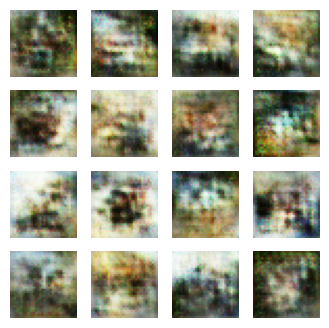

In [4]:
epochs = 5
latent_dim = 100

@tf.function
def train_step(real_batch):
    noise = tf.random.normal((tf.shape(real_batch)[0], latent_dim))
    fake = gen(noise, training=True)

    # Train discriminator
    with tf.GradientTape() as d_tape:
        d_real = disc(real_batch, training=True)
        d_fake = disc(fake, training=True)
        d_loss = bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)
    d_grads = d_tape.gradient(d_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(d_grads, disc.trainable_variables))

    # Train generator
    noise = tf.random.normal((tf.shape(real_batch)[0], latent_dim))
    with tf.GradientTape() as g_tape:
        fake = gen(noise, training=True)
        d_fake_for_g = disc(fake, training=True)
        g_loss = bce(tf.ones_like(d_fake_for_g), d_fake_for_g)
    g_grads = g_tape.gradient(g_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(g_grads, gen.trainable_variables))
    return d_loss, g_loss

for epoch in range(1, epochs+1):
    for real in dataset:
        d_loss, g_loss = train_step(real)
    print(f"Epoch {epoch}: D={d_loss.numpy():.4f} G={g_loss.numpy():.4f}")

# Muestras
noise = tf.random.normal((16, latent_dim))
samples = (gen(noise, training=False).numpy()+1)/2.0
fig, axes = plt.subplots(4,4, figsize=(4,4))
for ax, img in zip(axes.ravel(), samples):
    ax.imshow(img); ax.axis("off")
plt.show()


3) Muestras y FID

In [5]:
from src.metrics import save_image_grid, compute_fid_tf
from src.utils import append_summary_row, now_ts
import numpy as np, os, time

os.makedirs("../results/dcgan", exist_ok=True)
# Guardar grid con muestras
samples_vis = (samples*255).astype("uint8")
save_image_grid(samples_vis, "../results/dcgan/samples.png", ncols=4)

# FID opcional contra subset real
try:
    real_subset = ((x_train[:256])*255).astype("uint8")
    gen_subset = ((gen(tf.random.normal((256, latent_dim)), training=False).numpy()+1)/2.0)
    gen_subset = (gen_subset*255).astype("uint8")
    fid = compute_fid_tf(real_subset, gen_subset)
except Exception as e:
    fid = None
    print("FID no calculado:", e)

# Log a summary.csv
append_summary_row("../results/summary.csv", {
    "timestamp": now_ts(),
    "module": "gan",
    "model": "DCGAN",
    "dataset": "CIFAR-10",
    "accuracy": "",
    "f1": "",
    "loss": "",
    "epochs": epochs,
    "params": "",
    "train_time_s": "",
    "notes": f"FID={fid}" if fid is not None else "FID N/A"
})
print("Artefactos en results/dcgan y resumen en results/summary.csv")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 139s 2us/step
Artefactos en results/dcgan y resumen en results/summary.csv
